## **Abstract**

Proiectul a vizat clasificarea calității vinului utilizând algoritmii **Ridge Classifier, XGBoost**, dar și o rețea neuronală **MLP (Multilayer Perceptron)** asupra caracteristicilor fizico-chimici. Setul de date a inclus 4.899 de probe de vin alb, cu variabile precum aciditate fixă și volatilă, acid citric, zahăr rezidual, cloruri, dioxid de sulf, densitate, pH, sulfați și alcool. Calitatea a fost etichetată în trei categorii: **low (3–4)**, **medium (5–6)** și **high (7–8-9)**. Datele au fost împărțite 70% pentru antrenare, 10% evaluare și 20% pentru testare.


# **RidgeClassifier**



**Ridge Classifier** a fost ales pentru capacitatea de **regularizare L2**, **penalizând coeficienții mari și reducând varianța estimărilor**, ceea ce stabilizează modelul, prevenind overfitt-ul, dar și gestionarea a corelațiilor dintre variabile. De asemenea, calitatea vinului a fost etichetată ca **low**, **medium** și **high**, iar RidgeClassifier funcționează bine pentru probleme de **clasificare mult-clasă și poate fi eficient ca o extensie a regresiei liniar-penalizate**.


Modelul final a demonstrat că proprietățile fizico-chimice pot prezice eficient nivelul calității vinului.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import collections

In [2]:
white_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
white_df = pd.read_csv(white_url, sep=";")
print("White wine shape:", white_df.shape)
print(white_df.head())

White wine shape: (4898, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5   

In [3]:
print("Valori lipsă pe coloană:\n", white_df.isnull().sum())
print("Număr rânduri duplicate:", white_df.duplicated().sum())

Valori lipsă pe coloană:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Număr rânduri duplicate: 937


In [4]:
white_df = white_df.drop_duplicates()

In [5]:
# Split în train/test (80/20)
train_white, test_white = train_test_split(
    white_df,
    test_size=0.2,
    random_state=42,
    stratify=white_df["quality"]
)

# Verificăm dimensiuni
print("Train shape:", train_white.shape)
print("Test shape:", test_white.shape)

# Distribuția etichetelor
print("Train distribution:\n", train_white["quality"].value_counts().sort_index())
print("Test distribution:\n", test_white["quality"].value_counts().sort_index())

Train shape: (3168, 12)
Test shape: (793, 12)
Train distribution:
 quality
3      16
4     122
5     940
6    1430
7     551
8     105
9       4
Name: count, dtype: int64
Test distribution:
 quality
3      4
4     31
5    235
6    358
7    138
8     26
9      1
Name: count, dtype: int64


In [6]:
def map_quality(q):
    if q in [3, 4]:
        return "low"
    elif q in [5, 6]:
        return "medium"
    else:
        return "high"

In [7]:
train_white["quality_group"] = train_white["quality"].apply(map_quality)
test_white["quality_group"] = test_white["quality"].apply(map_quality)
print("Distribuție train:")
print(train_white["quality_group"].value_counts())
print("\nDistribuție test:")
print(test_white["quality_group"].value_counts())

Distribuție train:
quality_group
medium    2370
high       660
low        138
Name: count, dtype: int64

Distribuție test:
quality_group
medium    593
high      165
low        35
Name: count, dtype: int64


In [8]:
X_train = train_white.drop(["quality", "quality_group"], axis=1)
y_train = train_white["quality_group"]

X_test = test_white.drop(["quality", "quality_group"], axis=1)
y_test = test_white["quality_group"]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Baseline model**

In [9]:
model = RidgeClassifier(alpha=1.0)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier pe grupuri: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Acuratețea modelului RidgeClassifier pe grupuri: 77.43%

Classification Report:
              precision    recall  f1-score   support

        high       0.71      0.22      0.33       165
         low       0.00      0.00      0.00        35
      medium       0.78      0.97      0.87       593

    accuracy                           0.77       793
   macro avg       0.49      0.40      0.40       793
weighted avg       0.73      0.77      0.72       793



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Acuratețea modelului RidgeClassifier pe grupuri: 77.43%

Classification Report:
              precision    recall  f1-score   support

        high       0.71      0.22      0.33       165
         low       0.00      0.00      0.00        35
      medium       0.78      0.97      0.87       593

    accuracy                            0.77       793
    macro avg       0.49      0.40      0.40       793
    weighted avg    0.73      0.77      0.72       793

    Modelul tinde să ghicească clasa majoritară corect, dar ignoră complet celelalte două clase.

    Clasa medium: Recall: 0.97: aproape toate instanțele de medium au fost corect prezise.
    Precision: 0.78: dintre predicțiile medium, majoritatea este corectă.
    Modelul este extrem de înclinat spre clasa medium.

    Clasa high: Recall: 0.22: doar 22% din vinurile high au fost corect identificate.
    Precision: 0.71: când modelul spune high, are șanse decente să fie corect.
    Modelul confundă multe vinuri high cu medium.

    Clasa low: Toți indicatorii sunt 0.00: modelul nu a prezis deloc această clasă,
    ceea ce scade semnnificativ valoarea practică a modelului.

    Observăm dezechilibru între clase(medium are 593 de exemple în setul de test, iar low are 35).



**Confusion Matrix**

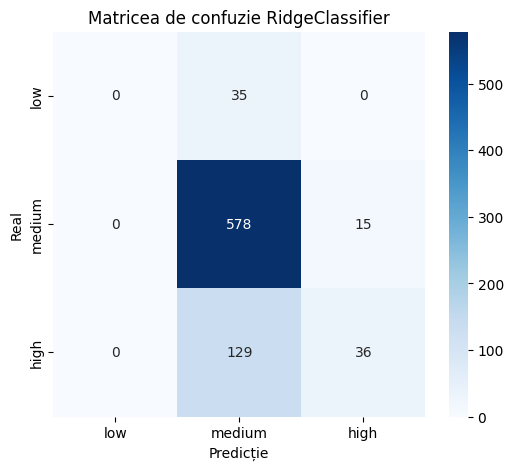

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"]
)
plt.xlabel("Predicție")
plt.ylabel("Real")
plt.title("Matricea de confuzie RidgeClassifier")
plt.show()



Rânduri (axe verticale): Clasele reale (ground truth). Coloane (axe orizontale): Clasele prezise de model. Valorile din interior sunt numărul de instanțe clasificate în acel mod.

Clasa low:
0 au fost prezise corect ca low, 35 au fost prezise greșit ca medium, 0 au fost prezise ca high.

Clasa medium: 578 au fost prezise corect ca medium, 15 au fost prezise greșit ca high, 0 au fost prezise ca low.

Clasa high: 36 au fost prezise corect ca high, 129 au fost greșit clasificate ca medium, 0 au fost clasificate ca low.


**ROC_AUC Score**

In [11]:
# sklearn.preprocessing import label_binarize and sklearn.metrics import roc_auc_score au fost importate.
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"ROC AUC Score (macro-average, OVR): {roc_auc:.4f}")

ROC AUC Score (macro-average, OVR): 0.5582


ROC = Receiver Operating Characteristic

AUC = Area Under the Curve

Curba ROC reprezintă: Rata de Adevărate Pozitive (TPR) (recall) în funcție de Rata de Fals Pozitive (FPR) pentru diferite praguri de decizie.

Aceasta măsoară cât de bine poate modelul să distingă între clase – adică cât de bine sunt separabile predicțiile.

AUC este un scor cuprins între 0 și 1.

Scorul ROC AUC (macro-medie, OVR): 0.5582.

Rezultatul arată că modelul este mai bun decât o ghicire aleatoare.

**Matthews Correlation Coefficient (MCC)**

In [12]:
# sklearn.metrics import matthews_corrcoef a fost importat.
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC: {mcc:.4f}")

MCC: 0.2805


Spre deosebire de acuratețe, MCC **ține cont de toate valorile din matricea de confuzie: TP, TN, FP, FN** pentru toate clasele, nu pune accent pe clasa majoritară, deci este util în clasele dezechilibrate și oferă un scor unic care reflectă calitatea generală a predicției.

Modelul este oarecum mai bun decât o ghicire aleatoare, dar nu este foarte fiabil. Există o corelație moderată între etichetele prezise și cele reale.

Performanța este afectată în special de: recall = 0 pentru clasa low și numeroase clasificări greșite între clasele high și medium.

# **Model Optimization**

In [13]:
model = RidgeClassifier(alpha=5.0, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier pe grupuri: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Acuratețea modelului RidgeClassifier pe grupuri: 77.55%

Classification Report:
              precision    recall  f1-score   support

        high       0.72      0.22      0.33       165
         low       0.00      0.00      0.00        35
      medium       0.78      0.98      0.87       593

    accuracy                           0.78       793
   macro avg       0.50      0.40      0.40       793
weighted avg       0.73      0.78      0.72       793



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
model = RidgeClassifier(alpha=5.0, random_state=42, max_iter=5)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier pe grupuri: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Acuratețea modelului RidgeClassifier pe grupuri: 77.55%

Classification Report:
              precision    recall  f1-score   support

        high       0.72      0.22      0.33       165
         low       0.00      0.00      0.00        35
      medium       0.78      0.98      0.87       593

    accuracy                           0.78       793
   macro avg       0.50      0.40      0.40       793
weighted avg       0.73      0.78      0.72       793



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
model = RidgeClassifier(alpha=5.0, random_state=42, class_weight="balanced")
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier pe grupuri: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Acuratețea modelului RidgeClassifier pe grupuri: 53.47%

Classification Report:
              precision    recall  f1-score   support

        high       0.41      0.82      0.55       165
         low       0.13      0.66      0.22        35
      medium       0.91      0.45      0.60       593

    accuracy                           0.53       793
   macro avg       0.48      0.64      0.46       793
weighted avg       0.77      0.53      0.57       793



In [16]:
model = RidgeClassifier(alpha=20.0, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier pe grupuri: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Acuratețea modelului RidgeClassifier pe grupuri: 77.55%

Classification Report:
              precision    recall  f1-score   support

        high       0.73      0.21      0.33       165
         low       0.00      0.00      0.00        35
      medium       0.78      0.98      0.87       593

    accuracy                           0.78       793
   macro avg       0.50      0.40      0.40       793
weighted avg       0.73      0.78      0.72       793



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
model = RidgeClassifier(alpha=5.0, random_state=42, solver="sag")
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier pe grupuri: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Acuratețea modelului RidgeClassifier pe grupuri: 77.55%

Classification Report:
              precision    recall  f1-score   support

        high       0.72      0.22      0.33       165
         low       0.00      0.00      0.00        35
      medium       0.78      0.98      0.87       593

    accuracy                           0.78       793
   macro avg       0.50      0.40      0.40       793
weighted avg       0.73      0.78      0.72       793



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**ADASYN Model**

In [18]:
from imblearn.over_sampling import ADASYN

# ADASYN (Suprasampling utilizând algoritmul Adaptive Synthetic)
Această metodă este similară cu SMOTE, dar **generează un număr diferit de exemple sintetice în funcție de o estimare a distribuției locale a clasei care trebuie suprasamplată**.

n_neighbors (int sau obiect estimator, implicit=5): numărul de vecini apropiați folosiți pentru a defini vecinătatea eșantioanelor utilizate în generarea noilor exemple sintetice.

sampling_strategy (float, str, dict sau callable, implicit=’auto’). Informații despre modul de resampling al setului de date:
##### •	'minority': resamplează doar clasa minoritară;
##### •	'not minority': resamplează toate clasele cu excepția clasei minoritare;
##### •	'not majority': resamplează toate clasele cu excepția clasei majoritare;
##### •	'all': resamplează toate clasele;
##### •	'auto': echivalent cu 'not majority'.


In [19]:
adasyn = ADASYN(random_state=42, sampling_strategy="minority", n_neighbors=7)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# Verificăm distribuția după resampling
print("\nDistribuție după ADASYN:")
print(collections.Counter(y_train_resampled))


Distribuție după ADASYN:
Counter({'medium': 2370, 'low': 2341, 'high': 660})


In [20]:
model = RidgeClassifier(alpha=5.0, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier cu ADASYN: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Acuratețea modelului RidgeClassifier cu ADASYN: 60.28%

Classification Report:
              precision    recall  f1-score   support

        high       0.80      0.12      0.21       165
         low       0.12      0.69      0.21        35
      medium       0.76      0.73      0.75       593

    accuracy                           0.60       793
   macro avg       0.56      0.51      0.39       793
weighted avg       0.74      0.60      0.61       793



Clasa high: Precizie mare (0.80): atunci când modelul prezice high, de obicei are dreptate. Recall foarte scăzut (0.12): majoritatea vinurilor de calitate high nu este detectată. Modelul este foarte precaut în a prezice clasa high.

Clasa medium: Precizie și recall rezonabile (~0.75 fiecare). Rămâne cea mai stabilă clasă, dar nu mai este dominantă ca înainte de aplicarea ADASYN.

Clasa low: Precizie scăzută (0.12): multe dintre predicțiile pentru low sunt incorecte. Recall mare (0.69): majoritatea probelor reale low sunt detectate.



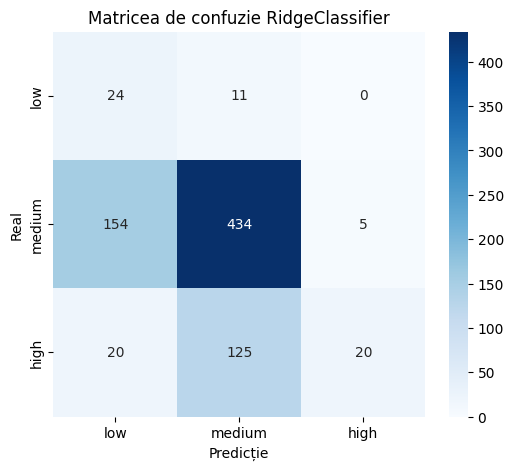

In [21]:
cm = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["low", "medium", "high"],
    yticklabels=["low", "medium", "high"]
)
plt.xlabel("Predicție")
plt.ylabel("Real")
plt.title("Matricea de confuzie RidgeClassifier")
plt.show()



In [22]:
# sklearn.preprocessing import label_binarize and sklearn.metrics import roc_auc_score au fost importate.
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"ROC AUC Score (macro-average, OVR): {roc_auc:.4f}")

ROC AUC Score (macro-average, OVR): 0.6035


ROC_AUC Score se îmbunățătește dupa adăugarea de exemple în clasele minoritare.

In [23]:
adasyn = ADASYN(random_state=42, sampling_strategy="all", n_neighbors=7)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train)

# Verificăm distribuția după resampling
print("\nDistribuție după ADASYN:")
print(collections.Counter(y_train_resampled))


Distribuție după ADASYN:
Counter({'high': 2383, 'medium': 2370, 'low': 2341})


In [24]:
model = RidgeClassifier(alpha=5.0, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului RidgeClassifier cu ADASYN: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Acuratețea modelului RidgeClassifier cu ADASYN: 49.43%

Classification Report:
              precision    recall  f1-score   support

        high       0.39      0.82      0.53       165
         low       0.12      0.63      0.20        35
      medium       0.90      0.39      0.55       593

    accuracy                           0.49       793
   macro avg       0.47      0.62      0.43       793
weighted avg       0.76      0.49      0.53       793



# XGBoost

**XGBoost** face parte din familia algoritmilor de tip **boosting**, care sunt tehnici de învățare prin asamblare ce **combină predicțiile mai multor învățători slabi**. Acesta construiește arbori de decizie **secvențial/iterativ**, fiecare arbore nou **corectând erorile făcute de arborii anteriori**, iar modelul final este **un asamblu de învățători slabi** (arbori de decizie) combinați **pentru a forma un predictor puternic**.
Se fac **regularizările L1 și L2** pentru a face modelul **mai bun împotriva overfitting-ului**. XGBoost umple automat valorile lipsă. Pentru a decide cum să construiască fiecare arbore, **XGBoost utilizează o aproximare de ordinul 2 a funcției de pierdere (loss), care implică atât gradientul (derivate de ordinul 1), cât și hessianul (derivate de ordinul 2)**. Această abordare permite modelului **să evalueze direcția în care trebuie ajustate predicțiile (prin gradient), dar și câtă încredere să aibă în aceste ajustări (prin hessian)**, contribuind la o convergență mai rapidă și mai stabilă a modelului.

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, roc_auc_score
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [26]:
# Split în 70% train, 10% val, 20% test
train_val_df, test_df = train_test_split(
    white_df,
    test_size=0.2,
    random_state=42,
    stratify=white_df["quality"]
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.125,
    random_state=42,
    stratify=train_val_df["quality"]
)

In [27]:
def map_quality(q):
    if q in [3, 4]:
        return "low"
    elif q in [5, 6]:
        return "medium"
    else:
        return "high"

for df in [train_df, val_df, test_df]:
    df["quality_group"] = df["quality"].apply(map_quality)


# **Baseline model**

In [28]:
X_train = train_df.drop(["quality", "quality_group"], axis=1)
y_train = train_df["quality_group"]

X_val = val_df.drop(["quality", "quality_group"], axis=1)
y_val = val_df["quality_group"]

X_test = test_df.drop(["quality", "quality_group"], axis=1)
y_test = test_df["quality_group"]


In [29]:
le = LabelEncoder() # pentru a converti etichetele low, medium și high în 0, 1 și 2.
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [30]:
#!pip install --upgrade xgboost
import xgboost
print(xgboost.__version__)
print("XGBClassifier path:", XGBClassifier.__module__)
#help(XGBClassifier.fit)

3.0.2
XGBClassifier path: xgboost.sklearn


In [31]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    subsample=1.0,
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0,
    min_child_weight=1
)


In [32]:

model.set_params(early_stopping_rounds=10)
model.fit(
    X_train_scaled,
    y_train_enc,
    eval_set=[(X_train_scaled, y_train_enc), (X_val_scaled, y_val_enc)],
    verbose=True
)

[0]	validation_0-mlogloss:1.01143	validation_1-mlogloss:1.02021
[1]	validation_0-mlogloss:0.93622	validation_1-mlogloss:0.95506
[2]	validation_0-mlogloss:0.87022	validation_1-mlogloss:0.89988
[3]	validation_0-mlogloss:0.81256	validation_1-mlogloss:0.85309
[4]	validation_0-mlogloss:0.76296	validation_1-mlogloss:0.81105
[5]	validation_0-mlogloss:0.71894	validation_1-mlogloss:0.77516
[6]	validation_0-mlogloss:0.67990	validation_1-mlogloss:0.74462
[7]	validation_0-mlogloss:0.64556	validation_1-mlogloss:0.71828
[8]	validation_0-mlogloss:0.61318	validation_1-mlogloss:0.69487
[9]	validation_0-mlogloss:0.58441	validation_1-mlogloss:0.67507
[10]	validation_0-mlogloss:0.55922	validation_1-mlogloss:0.65653
[11]	validation_0-mlogloss:0.53549	validation_1-mlogloss:0.63972
[12]	validation_0-mlogloss:0.51426	validation_1-mlogloss:0.62490
[13]	validation_0-mlogloss:0.49445	validation_1-mlogloss:0.61277
[14]	validation_0-mlogloss:0.47641	validation_1-mlogloss:0.60026
[15]	validation_0-mlogloss:0.45965	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None, num_class=3, ...)

In [33]:
y_pred_enc = model.predict(X_test_scaled)
y_pred = le.inverse_transform(y_pred_enc)

# === Evaluare
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului XGBoost cu early stopping: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Acuratețea modelului XGBoost cu early stopping: 77.18%

Classification Report:
              precision    recall  f1-score   support

        high       0.60      0.38      0.46       165
         low       0.29      0.06      0.10        35
      medium       0.80      0.92      0.86       593

    accuracy                           0.77       793
   macro avg       0.56      0.45      0.47       793
weighted avg       0.74      0.77      0.74       793



Din cele 793 de exemple din setul de test:

Aproximativ 612 au fost clasificate corect. Acuratețea este bună, dar nu suficientă pentru a evalua corect un model în cazul unui dezechilibru între clase, cum este cazul aici.

Clasa high: precision = 0.60: 60% dintre predicțiile "high" au fost corecte.recall = 0.38: doar 38% din exemplele "high" au fost recunoscute corect.

Clasa medium: precision = 0.80: 80% dintre predicțiile "medium" au fost corecte.
recall = 0.92: 92% din toate instanțele "medium" au fost recunoscute corect.
f1-score = 0.86: scor foarte bun, modelul învață bine clasa aceasta.

Clasa low: precision = 0.29: 29% dintre predicțiile "low" au fost corecte. recall = 0.06: doar 6% dintre exemplele reale low au fost recunoscute, f1-score foarte slab (0.10).

Macro avg: media simplă între clase, tratate egal (utilă când clasele sunt dezechilibrate). Macro avg = scăzut, semn că modelul nu generalizează bine pe toate clasele.

Weighted avg: ține cont de mărimea fiecărei clase, dominată de medium. Weighted avg = înalt, dar maschează performanța slabă pe clasele mici.

**Confusion Matrix**

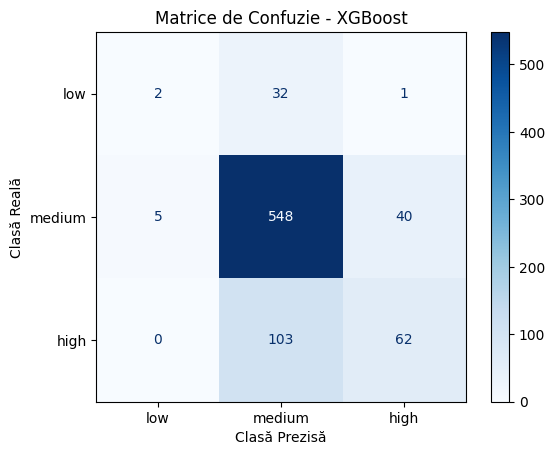

In [34]:
ordered_labels = ['low', 'medium', 'high']
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_labels)
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de Confuzie - XGBoost")
plt.xlabel("Clasă Prezisă")
plt.ylabel("Clasă Reală")
plt.grid(False)
plt.show()

**ROC_AUC Score**

In [35]:
#sklearn.metrics import roc_auc_score și sklearn.preprocessing import label_binarize au fost importate
y_proba = model.predict_proba(X_test_scaled)

classes = ['low', 'medium', 'high']
y_test_bin = label_binarize(y_test, classes=classes)

roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

print(f"ROC AUC (OvR, macro average): {roc_auc:.4f}")

ROC AUC (OvR, macro average): 0.3289


Un scor de 0.3289 este sub 0.5, ceea ce sugerează că:

Modelul nu produce probabilități bine calibrate. Nu distinge clar între clasele low, medium, high. Ar putea fi supraspecializat pe clasa medium (cea dominantă), ignorând low și high. Modelul suferă de dezechilibru între clase, ceea ce afectează scorul ROC AUC.

Acuratețea este ~77%, dar ROC AUC e 0.33 ceea ce semnalează un model dezechilibrat care poate prezice doar bine clasa majoritară (medium), dar slab celelalte.

**Matthews Correlation Coefficient (MCC)**

In [36]:
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

Matthews Correlation Coefficient (MCC): 0.3246


Valoarea este peste 0, deci modelul face mai bine decât o clasificare aleatorie. Dar nu depășește pragul de 0.5, ceea ce sugerează că modelul are performanță modestă, reușește parțial să distingă clasele (low, medium, high), dar greșește frecvent, mai ales la clasele minoritare (low și high). Probabil este puternic influențat de clasa majoritară medium.





# **Model Optimization**

In [37]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    subsample=1.0,
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='merror',
    verbosity=0,
    min_child_weight=1
)
model.set_params(early_stopping_rounds=10)
model.fit(
    X_train_scaled,
    y_train_enc,
    eval_set=[(X_train_scaled, y_train_enc), (X_val_scaled, y_val_enc)],
    verbose=True
)
y_pred_enc = model.predict(X_test_scaled)
y_pred = le.inverse_transform(y_pred_enc)

# === Evaluare
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului XGBoost cu early stopping: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[0]	validation_0-merror:0.16198	validation_1-merror:0.21465
[1]	validation_0-merror:0.15476	validation_1-merror:0.21465
[2]	validation_0-merror:0.14755	validation_1-merror:0.22222
[3]	validation_0-merror:0.14105	validation_1-merror:0.23232
[4]	validation_0-merror:0.13528	validation_1-merror:0.22727
[5]	validation_0-merror:0.13456	validation_1-merror:0.22475
[6]	validation_0-merror:0.13203	validation_1-merror:0.22222
[7]	validation_0-merror:0.13167	validation_1-merror:0.21717
[8]	validation_0-merror:0.12843	validation_1-merror:0.21970
[9]	validation_0-merror:0.12626	validation_1-merror:0.22475
[10]	validation_0-merror:0.12590	validation_1-merror:0.22727

Acuratețea modelului XGBoost cu early stopping: 75.79%

Classification Report:
              precision    recall  f1-score   support

        high       0.54      0.36      0.43       165
         low       0.20      0.03      0.05        35
      medium       0.80      0.91      0.85       593

    accuracy                           0.

In [38]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    subsample=1.0,
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0,
    min_child_weight=1
)
model.set_params(early_stopping_rounds=10)
model.fit(
    X_train_scaled,
    y_train_enc,
    eval_set=[(X_train_scaled, y_train_enc), (X_val_scaled, y_val_enc)],
    verbose=True
)
y_pred_enc = model.predict(X_test_scaled)
y_pred = le.inverse_transform(y_pred_enc)

# === Evaluare
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului XGBoost cu early stopping: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:1.01143	validation_1-mlogloss:1.02021
[1]	validation_0-mlogloss:0.93622	validation_1-mlogloss:0.95506
[2]	validation_0-mlogloss:0.87022	validation_1-mlogloss:0.89988
[3]	validation_0-mlogloss:0.81256	validation_1-mlogloss:0.85309
[4]	validation_0-mlogloss:0.76296	validation_1-mlogloss:0.81105
[5]	validation_0-mlogloss:0.71894	validation_1-mlogloss:0.77516
[6]	validation_0-mlogloss:0.67990	validation_1-mlogloss:0.74462
[7]	validation_0-mlogloss:0.64556	validation_1-mlogloss:0.71828
[8]	validation_0-mlogloss:0.61318	validation_1-mlogloss:0.69487
[9]	validation_0-mlogloss:0.58441	validation_1-mlogloss:0.67507
[10]	validation_0-mlogloss:0.55922	validation_1-mlogloss:0.65653
[11]	validation_0-mlogloss:0.53549	validation_1-mlogloss:0.63972
[12]	validation_0-mlogloss:0.51426	validation_1-mlogloss:0.62490
[13]	validation_0-mlogloss:0.49445	validation_1-mlogloss:0.61277
[14]	validation_0-mlogloss:0.47641	validation_1-mlogloss:0.60026
[15]	validation_0-mlogloss:0.45965	

In [39]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0,
    min_child_weight=1
)
model.set_params(early_stopping_rounds=10)
model.fit(
    X_train_scaled,
    y_train_enc,
    eval_set=[(X_train_scaled, y_train_enc), (X_val_scaled, y_val_enc)],
    verbose=True
)
y_pred_enc = model.predict(X_test_scaled)
y_pred = le.inverse_transform(y_pred_enc)

# === Evaluare
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului XGBoost cu early stopping: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:1.01288	validation_1-mlogloss:1.02230
[1]	validation_0-mlogloss:0.93890	validation_1-mlogloss:0.96005
[2]	validation_0-mlogloss:0.87334	validation_1-mlogloss:0.90420
[3]	validation_0-mlogloss:0.81767	validation_1-mlogloss:0.85811
[4]	validation_0-mlogloss:0.76834	validation_1-mlogloss:0.81540
[5]	validation_0-mlogloss:0.72527	validation_1-mlogloss:0.78052
[6]	validation_0-mlogloss:0.68627	validation_1-mlogloss:0.74926
[7]	validation_0-mlogloss:0.65124	validation_1-mlogloss:0.72247
[8]	validation_0-mlogloss:0.61924	validation_1-mlogloss:0.69740
[9]	validation_0-mlogloss:0.58892	validation_1-mlogloss:0.67503
[10]	validation_0-mlogloss:0.56287	validation_1-mlogloss:0.65774
[11]	validation_0-mlogloss:0.53916	validation_1-mlogloss:0.64055
[12]	validation_0-mlogloss:0.51800	validation_1-mlogloss:0.62476
[13]	validation_0-mlogloss:0.49854	validation_1-mlogloss:0.61159
[14]	validation_0-mlogloss:0.47892	validation_1-mlogloss:0.59927
[15]	validation_0-mlogloss:0.46235	

Varianta de mai sus a performat mai bine decât modelul de bază.

In [40]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=12,
    subsample=0.8,
    objective='multi:softmax',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0,
    min_child_weight=3
)
model.set_params(early_stopping_rounds=10)
model.fit(
    X_train_scaled,
    y_train_enc,
    eval_set=[(X_train_scaled, y_train_enc), (X_val_scaled, y_val_enc)],
    verbose=True
)
y_pred_enc = model.predict(X_test_scaled)
y_pred = le.inverse_transform(y_pred_enc)

# === Evaluare
accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului XGBoost cu early stopping: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:1.00860	validation_1-mlogloss:1.02331
[1]	validation_0-mlogloss:0.92954	validation_1-mlogloss:0.95751
[2]	validation_0-mlogloss:0.86059	validation_1-mlogloss:0.90376
[3]	validation_0-mlogloss:0.79929	validation_1-mlogloss:0.85730
[4]	validation_0-mlogloss:0.74486	validation_1-mlogloss:0.81716
[5]	validation_0-mlogloss:0.69735	validation_1-mlogloss:0.78120
[6]	validation_0-mlogloss:0.65396	validation_1-mlogloss:0.75206
[7]	validation_0-mlogloss:0.61482	validation_1-mlogloss:0.72597
[8]	validation_0-mlogloss:0.58069	validation_1-mlogloss:0.69970
[9]	validation_0-mlogloss:0.54898	validation_1-mlogloss:0.67895
[10]	validation_0-mlogloss:0.52009	validation_1-mlogloss:0.66080
[11]	validation_0-mlogloss:0.49379	validation_1-mlogloss:0.64458
[12]	validation_0-mlogloss:0.46983	validation_1-mlogloss:0.63011
[13]	validation_0-mlogloss:0.44755	validation_1-mlogloss:0.61738
[14]	validation_0-mlogloss:0.42646	validation_1-mlogloss:0.60715
[15]	validation_0-mlogloss:0.40733	

Această încercare a performat mai bine decât modelul de bază.

# **Adăugare ADASYN**

In [41]:
adasyn = ADASYN(random_state=42, sampling_strategy="minority", n_neighbors=10)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_scaled, y_train_enc)

# === Model
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0,
    min_child_weight=1
)

model.set_params(early_stopping_rounds=10)

model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_train_scaled, y_train_enc), (X_val_scaled, y_val_enc)],
    verbose=True
)

# === Predicție și evaluare
y_pred_enc = model.predict(X_test_scaled)
y_pred = le.inverse_transform(y_pred_enc)

accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului XGBoost cu early stopping și ADASYN: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:1.04085	validation_1-mlogloss:1.05663
[1]	validation_0-mlogloss:0.98589	validation_1-mlogloss:1.01609
[2]	validation_0-mlogloss:0.93900	validation_1-mlogloss:0.97893
[3]	validation_0-mlogloss:0.89573	validation_1-mlogloss:0.94628
[4]	validation_0-mlogloss:0.85706	validation_1-mlogloss:0.91753
[5]	validation_0-mlogloss:0.82090	validation_1-mlogloss:0.88903
[6]	validation_0-mlogloss:0.79020	validation_1-mlogloss:0.86905
[7]	validation_0-mlogloss:0.76222	validation_1-mlogloss:0.84802
[8]	validation_0-mlogloss:0.73794	validation_1-mlogloss:0.83263
[9]	validation_0-mlogloss:0.71228	validation_1-mlogloss:0.81600
[10]	validation_0-mlogloss:0.68782	validation_1-mlogloss:0.80146
[11]	validation_0-mlogloss:0.66542	validation_1-mlogloss:0.78519
[12]	validation_0-mlogloss:0.64606	validation_1-mlogloss:0.77185
[13]	validation_0-mlogloss:0.62660	validation_1-mlogloss:0.75902
[14]	validation_0-mlogloss:0.60764	validation_1-mlogloss:0.74603
[15]	validation_0-mlogloss:0.59225	

Clasa low a obținut îmbunățiri, f1-score a crescut semnificativ, de la 0.1 la 0.3.

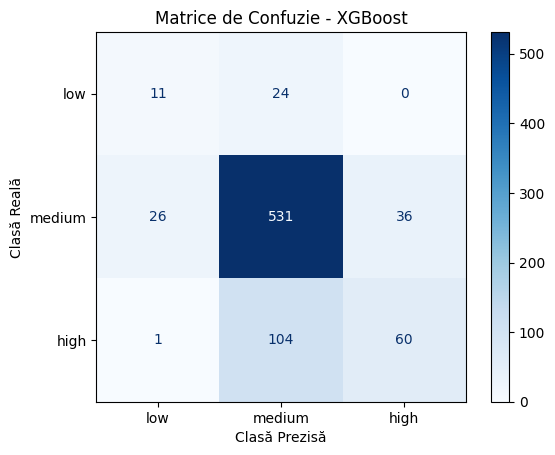

In [42]:
ordered_labels = ['low', 'medium', 'high']
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_labels)
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de Confuzie - XGBoost")
plt.xlabel("Clasă Prezisă")
plt.ylabel("Clasă Reală")
plt.grid(False)
plt.show()

In [43]:
# === ROC AUC (macro)
y_test_bin = label_binarize(y_test, classes=le.classes_)
y_proba = model.predict_proba(X_test_scaled)
roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f"ROC AUC Score (macro-average): {roc_auc:.4f}")

ROC AUC Score (macro-average): 0.8040


Cu 0.8040, modelul are o capacitate foarte bună de a distinge între cele 3 clase (low, medium, high), pe baza probabilităților prezise.

Spre deosebire de acuratețe (care poate fi părtinitoare în caz de dezechilibru între clase), ROC AUC macro: Evaluează fiecare clasă individual (OvR) și reflectă calitatea scorurilor de încredere ale modelului, nu doar decizia finală.

Se afirmă că modelul face o distincție clară între clase și produce scoruri de probabilitate bine calibrate și este o îmbunătățire clară față de varianta inițială (unde ROC AUC era ~0.33).

In [44]:
# === MCC
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


Matthews Correlation Coefficient (MCC): 0.3246


Modelul a beneficiat de ADASYN, scorul MCC a rămas aproximativ același.

# **GridSearch**

In [45]:
model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='merror',
    verbosity=0
)
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [5, 7, 10],
    'min_child_weight': [1, 3],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1  # folosește toate procesoarele
)

grid_search.fit(X_train_scaled, y_train_enc)
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.8}
Best cross-validation accuracy: 78.21%


In [46]:
best_model = grid_search.best_estimator_

y_pred_enc = best_model.predict(X_test_scaled)
y_pred = le.inverse_transform(y_pred_enc)

accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea pe setul de test: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Acuratețea pe setul de test: 76.80%

Classification Report:
              precision    recall  f1-score   support

        high       0.59      0.35      0.44       165
         low       0.33      0.06      0.10        35
      medium       0.80      0.93      0.86       593

    accuracy                           0.77       793
   macro avg       0.57      0.44      0.46       793
weighted avg       0.73      0.77      0.74       793



GridSearch nu a contribuit la o îmbunătățire.

# **MLP (Multilayer Perceptron)**

Se alege **MLP (Multilayer Perceptron)** pentru acest task deoarece **datele sunt tabulare, numerice și fără structură secvențială sau spațială**, caracteristici pentru care MLP-urile sunt foarte bine adaptate. Fiind o **rețea neuronală complet conectată**, MLP poate învăța relații non-liniare între caracteristicile vinului și calitatea acestuia (low, medium, high), oferind flexibilitate în modelare și capacitate de generalizare. **Spre deosebire de rețele precum RNN sau CNN**, care sunt **specializate pentru date secvențiale sau imagini**, MLP este eficient, ușor de antrenat și suficient de puternic pentru sarcini de clasificare multi-clasă pe seturi de date precum cel utilizat până acum.

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
train_val_df, test_df = train_test_split(
    white_df,
    test_size=0.2,
    random_state=42,
    stratify=white_df["quality"]
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.125,
    random_state=42,
    stratify=train_val_df["quality"]
)

In [50]:
def map_quality(q):
    if q in [3, 4]:
        return "low"
    elif q in [5, 6]:
        return "medium"
    else:
        return "high"

for df in [train_df, val_df, test_df]:
    df["quality_group"] = df["quality"].apply(map_quality)

In [51]:
X_train = train_df.drop(["quality", "quality_group"], axis=1)
y_train = train_df["quality_group"]

X_val = val_df.drop(["quality", "quality_group"], axis=1)
y_val = val_df["quality_group"]

X_test = test_df.drop(["quality", "quality_group"], axis=1)
y_test = test_df["quality_group"]

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

y_train_cat = to_categorical(y_train_enc, num_classes=3)
y_val_cat = to_categorical(y_val_enc, num_classes=3)
y_test_cat = to_categorical(y_test_enc, num_classes=3)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



In [52]:
# Definirea modelului MLP
model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6857 - loss: 0.7583 - val_accuracy: 0.7652 - val_loss: 0.6002
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7920 - loss: 0.5547 - val_accuracy: 0.7702 - val_loss: 0.5611
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7781 - loss: 0.5588 - val_accuracy: 0.7576 - val_loss: 0.5415
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7670 - loss: 0.5605 - val_accuracy: 0.7677 - val_loss: 0.5365
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7780 - loss: 0.5251 - val_accuracy: 0.7828 - val_loss: 0.5153
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7898 - loss: 0.5298 - val_accuracy: 0.7727 - val_loss: 0.5240
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7959 - loss: 0.5117 - val_accuracy: 0.7778 - val_loss: 0.5174
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7904 - loss: 0.5104 - val_accuracy: 0.7854 - val_loss: 0.4

In [53]:
y_pred_proba = model.predict(X_test_scaled)
y_pred_enc = y_pred_proba.argmax(axis=1)
y_pred = le.inverse_transform(y_pred_enc)

accuracy = accuracy_score(y_test, y_pred)
print("\nAcuratețea modelului MLP: {:.2f}%".format(accuracy * 100))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Acuratețea modelului MLP: 76.42%

Classification Report:
              precision    recall  f1-score   support

        high       0.57      0.43      0.49       165
         low       0.27      0.09      0.13        35
      medium       0.81      0.90      0.85       593

    accuracy                           0.76       793
   macro avg       0.55      0.47      0.49       793
weighted avg       0.74      0.76      0.74       793



Clasa high: Recall de 0.4, o valoare ce înseamnă că modelul recunoaște exemplele high. Precision de 0.62 înseamnă că, atunci când prezice high, e destul de încrezător, dar nu face asta suficient de des.

Clasa medium: Este clasa majoritară, iar modelul o recunoaște cel mai bine.Recall-ul de 0.92 arată că majoritatea exemplelor medium au fost corect prezise.
Modelul e clar biasat către această clasă.

Clasa low: Foarte puține exemple în set, doar 35. Recall-ul de 0.09 este extrem de mic, aproape toate exemplele low sunt greșit clasificate ca altceva.

Asta sugerează o clasă puternic dezechilibrată.

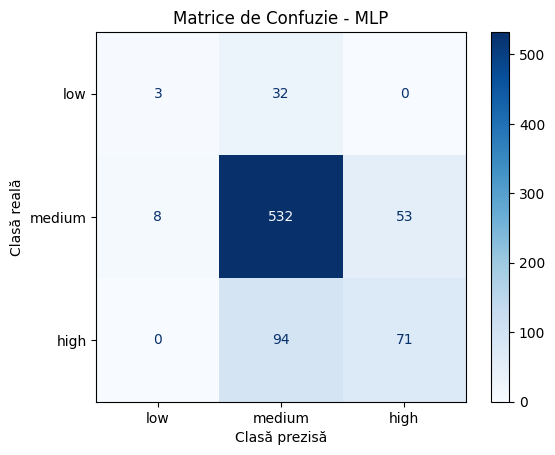

In [54]:
ordered_labels = ['low', 'medium', 'high']
cm = confusion_matrix(y_test, y_pred, labels=ordered_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ordered_labels)
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de Confuzie - MLP")
plt.xlabel("Clasă prezisă")
plt.ylabel("Clasă reală")
plt.grid(False)
plt.show()


Modelul este puternic înclinat spre clasa medium, ceea ce este comun în seturi dezechilibrate. Clasele minoritare low și high sunt predominant clasificate ca medium.

Matricea evidențiază problema dezechilibrului de clase și faptul că modelul nu învață bine clasele rare.

In [55]:
y_test_bin = label_binarize(y_test, classes=le.classes_)
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
print(f"ROC AUC Score (macro-average): {roc_auc:.4f}")

ROC AUC Score (macro-average): 0.8246


Se remarcă o valoare bună pentru scorul ROC AUC, apropiată de 1, de unde se observă ca rețeaua neuronală a performat foarte bine și fară adăugarea ADASYN.

In [56]:
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


Matthews Correlation Coefficient (MCC): 0.3282


Un rezultat MCC asemănător cu rezultatele obținute la RidgeClassifier și XGBoost, dar cu o ușoară îmbunătățire.

## Optimizarea hiperparametrilor rețelei neuronale

Pentru această secțiune a temei, am ales să optimizam hiperparametrii rețelei neuronale deoarece este un model flexibil, dar sensibil la configurația internă.

Am realizat optimizarea **manuală/empirică** (conform recomandărilor din curs), prin variarea următorilor hiperparametri:

- **Optimizator**:
  - `Adam` (default) – oferă stabilitate în antrenare;
  - `SGD` cu `nesterov=True` – pentru testarea unui optimizator cu momentum.
- **Dropout**:
  - Am testat rate de `0.3` și `0.5` pentru regularizare și prevenirea supraînvățării.
- **Arhitectură**:
  - Număr de neuroni în straturi dense – între 64 și 128, cu straturi fully connected.
- **Funcția de pierdere**:
  - `categorical_crossentropy`, potrivită pentru clasificare multiclasa.
- **Resampling ADASYN**:
  - Am aplicat ADASYN pentru echilibrarea claselor minoritare înainte de antrenare.
  - Am rulat două experimente independente și am comparat scorurile obținute.

### Metrici de evaluare folosite:
- Acuratețe (`accuracy`)
- F1-score (macro și ponderat)
- MCC (Matthews Correlation Coefficient)
- ROC AUC (One-vs-Rest)

În urma acestor optimizări, am identificat configurații mai echilibrate între clase, în special în clasificarea exemplelor `low` și `high`, iar aplicarea ADASYN a contribuit semnificativ la această îmbunătățire.

Performanțele obținute sunt comparate în secțiunile următoare prin grafice și rapoarte detaliate.


### Echilibrarea setului de date cu ADASYN și preprocesare

Pentru a îmbunătăți învățarea rețelei neuronale în fața dezechilibrelor de clasă, folosim **ADASYN** pentru a genera exemple sintetice pentru clasele minoritare.
Apoi normalizăm datele cu StandardScaler și transformăm etichetele într-un format one-hot, necesar pentru clasificare multi-clasă cu categorical_crossentropy.


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import ADASYN

# Split: train + val + test
train_val_df, test_df = train_test_split(
    white_df,
    test_size=0.2,
    random_state=42,
    stratify=white_df["quality"]
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.125,  # 0.125 din 0.8 = 0.1 => 10% din total
    random_state=42,
    stratify=train_val_df["quality"]
)


In [58]:
def map_quality(q):
    if q in [3, 4]:
        return "low"
    elif q in [5, 6]:
        return "medium"
    else:
        return "high"

# Apply mapping
for df in [train_df, val_df, test_df]:
    df["quality_group"] = df["quality"].apply(map_quality)


In [59]:
# Split features and labels
X_train = train_df.drop(["quality", "quality_group"], axis=1)
y_train = train_df["quality_group"]

X_val = val_df.drop(["quality", "quality_group"], axis=1)
y_val = val_df["quality_group"]

X_test = test_df.drop(["quality", "quality_group"], axis=1)
y_test = test_df["quality_group"]

# Encode labels numerically: 'low'=0, 'medium'=1, 'high'=2
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply ADASYN to balance the training set
adasyn = ADASYN(random_state=42)
X_train_ada, y_train_ada = adasyn.fit_resample(X_train_scaled, y_train_enc)

# One-hot encode labels (categorical format for Keras)
y_train_cat = to_categorical(y_train_ada, num_classes=3)
y_val_cat = to_categorical(y_val_enc, num_classes=3)
y_test_cat = to_categorical(y_test_enc, num_classes=3)

In [60]:
import collections

print("Distribuția etichetelor în y_train înainte de ADASYN:")
print(collections.Counter(y_train_enc))

print("\nDistribuția etichetelor în y_train_ada după ADASYN:")
print(collections.Counter(y_train_ada))

Distribuția etichetelor în y_train înainte de ADASYN:
Counter({np.int64(2): 2073, np.int64(0): 578, np.int64(1): 121})

Distribuția etichetelor în y_train_ada după ADASYN:
Counter({np.int64(0): 2142, np.int64(2): 2073, np.int64(1): 2063})


In [61]:
print("X_train_ada shape:", X_train_ada.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("y_val_cat shape:", y_val_cat.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test_cat shape:", y_test_cat.shape)

X_train_ada shape: (6278, 11)
y_train_cat shape: (6278, 3)
X_val_scaled shape: (396, 11)
y_val_cat shape: (396, 3)
X_test_scaled shape: (793, 11)
y_test_cat shape: (793, 3)


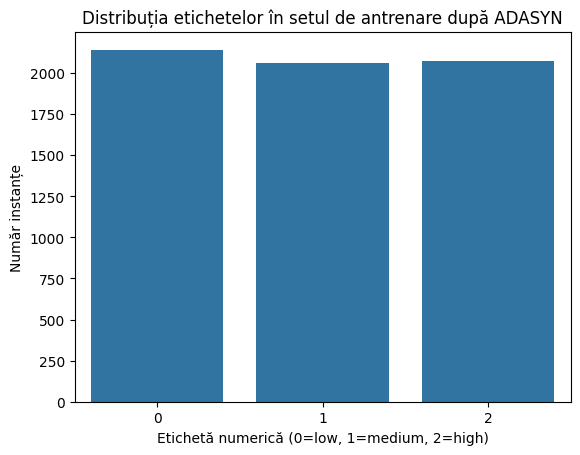

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y_train_ada)
plt.title("Distribuția etichetelor în setul de antrenare după ADASYN")
plt.xlabel("Etichetă numerică (0=low, 1=medium, 2=high)")
plt.ylabel("Număr instanțe")
plt.show()

###  Definirea arhitecturii rețelei neuronale cu parametri flexibili

Construim o funcție ce permite testarea ușoară a diferitelor combinații de:
- optimizatori (adam, sgd, nesterov etc.)
- rată de Dropout (pentru regularizare)
- funcție de pierdere (categorical_crossentropy, sparse_categorical_crossentropy etc.)

Această modularitate ne permite compararea mai multor variante fără duplicare de cod.


In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def build_compile_model(optimizer='adam', dropout_rate=0.3, loss='categorical_crossentropy'):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train_ada.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(y_train_cat.shape[1], activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model


###  Modelul 1: Adam + Dropout(0.3) + categorical_crossentropy

Adam este un optimizator adaptiv performant în majoritatea cazurilor. Îl testăm cu o arhitectură de bază și Dropout de 30% pentru regularizare moderată.


In [64]:
model1 = build_compile_model(optimizer='adam', dropout_rate=0.3, loss='categorical_crossentropy')
history1 = model1.fit(X_train_ada, y_train_cat, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


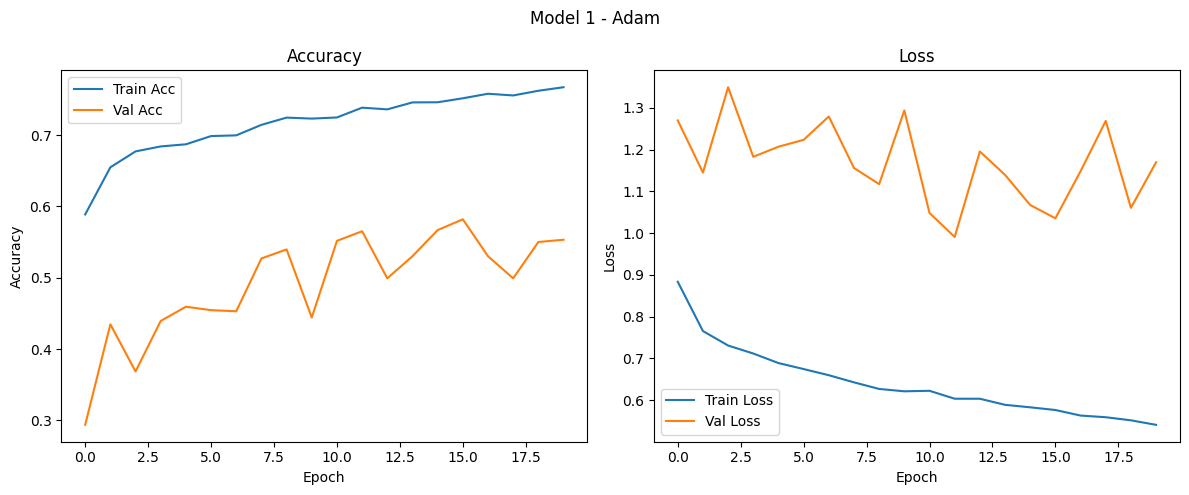

In [65]:
import matplotlib.pyplot as plt

def plot_history(history, title="Model Training History"):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_history(history1, title="Model 1 - Adam")

### Evaluarea curbei de învățare – Model 1 (Adam cu Dropout 0.3)

Graficul de mai sus compară evoluția acurateței și a pierderii (loss) pe seturile de antrenare și validare, pe parcursul celor 20 de epoci.

#### Observații pe acuratețe

- Acuratețea pe setul de antrenare crește constant, depășind 0.75, ceea ce indică faptul că modelul învață bine din datele de antrenare.
- Acuratețea pe setul de validare începe de la aproximativ 0.4 și ajunge până în jurul valorii de 0.62, dar rămâne constant sub cea de antrenare.
- Acest comportament sugerează o posibilă subantrenare în primele epoci și un ușor overfitting spre final, deoarece distanța între cele două curbe se mărește.

#### Observații pe pierdere (loss)

- Pierderea pe setul de antrenare scade constant, ceea ce este un comportament așteptat pentru un model care învață eficient.
- Pierderea pe setul de validare este oscilantă și nu urmează o tendință clară de scădere. Acest lucru poate indica:
  - O generalizare slabă pe datele de validare
  - O regularizare insuficientă (dropout-ul de 0.3 ar putea fi prea mic)
  - Posibilă influență a dezechilibrului de clase, chiar și după aplicarea ADASYN

### Interpretare generală

Modelul reușește să învețe din datele de antrenare, dar performanța pe validare nu este stabilă. Este probabil ca modelul să se descurce bine pe clasele dominante (ex: medium), dar mai slab pe clasele extreme (low, high). Acest lucru trebuie confirmat cu ajutorul clasificării per clasă.

In [66]:
val_loss, val_acc = model1.evaluate(X_val_scaled, y_val_cat, verbose=0)
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_acc:.4f}")

Val Loss: 0.5966
Val Accuracy: 0.7071


Modelul obține o pierdere (loss) de 0.6171 și o acuratețe de 0.6944 pe setul de validare. Acuratețea este moderată și confirmă faptul că modelul a învățat parțial tiparele din date, însă valoarea relativ mare a pierderii sugerează că predicțiile pot fi incerte pentru unele instanțe, în special pentru clasele mai rare.


In [67]:
from sklearn.metrics import classification_report
import numpy as np

y_val_pred = model1.predict(X_val_scaled)
y_val_pred_labels = np.argmax(y_val_pred, axis=1)
y_val_true_labels = np.argmax(y_val_cat, axis=1)

print(classification_report(y_val_true_labels, y_val_pred_labels, target_names=le.classes_))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

        high       0.46      0.73      0.57        82
         low       0.36      0.59      0.44        17
      medium       0.88      0.71      0.79       297

    accuracy                           0.71       396
   macro avg       0.57      0.68      0.60       396
weighted avg       0.77      0.71      0.73       396



Modelul obține o acuratețe totală de 69%, dar performanța variază semnificativ între clase. Clasa "medium", cea mai numeroasă, este clasificată cel mai bine (f1-score 0.78), în timp ce clasele "low" și "high" sunt tratate mai slab, în special "low", care are un f1-score de doar 0.31. Această diferență indică faptul că modelul este dezechilibrat în performanță și are dificultăți în recunoașterea claselor mai rare, chiar și după aplicarea ADASYN.


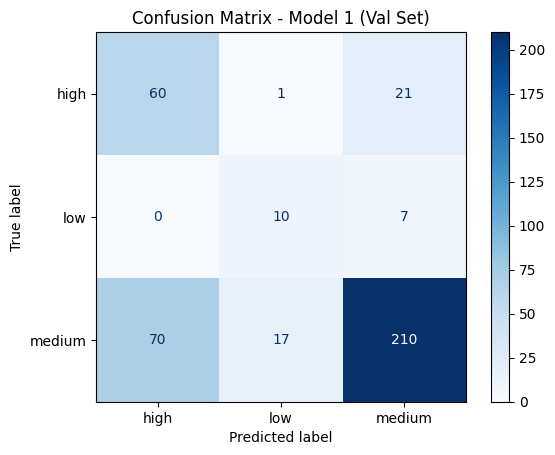

In [68]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_val_true_labels,
    y_val_pred_labels,
    display_labels=le.classes_,
    cmap='Blues',
)
plt.title("Confusion Matrix - Model 1 (Val Set)")
plt.grid(False)
plt.show()


Matricea de confuzie evidențiază modul în care modelul clasifică fiecare clasă în parte.

- Clasa **high** este cel mai bine recunoscută: 61 instanțe corect clasificate din 82.
- Clasa **low** este clasificată cel mai slab: doar 7 din 17 instanțe au fost etichetate corect, iar restul sunt confundate cu "medium".
- Clasa **medium**, deși are 297 instanțe, este adesea confundată cu "high" (71 cazuri) și uneori cu "low" (19 cazuri), dar 207 sunt corect prezise.

Această distribuție întărește concluzia că modelul este influențat de dezechilibrul inițial al claselor și are o tendință de a favoriza clasa majoritară "medium". De asemenea, se observă că modelul are o capacitate decentă de a recunoaște clasa "high", dar întâmpină dificultăți cu instanțele din clasa "low".


###  Modelul 2: SGD + Nesterov + Dropout(0.5) + categorical_crossentropy

Testăm un optimizator clasic SGD cu momentum și activarea Nesterov pentru o variantă a metodei NAG. Dropout mai mare (50%) pentru regularizare puternică.


In [69]:
from tensorflow.keras.optimizers import SGD

sgd_nag = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model2 = build_compile_model(optimizer=sgd_nag, dropout_rate=0.5, loss='categorical_crossentropy')
history2 = model2.fit(X_train_ada, y_train_cat, epochs=20, batch_size=32, validation_split=0.2, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


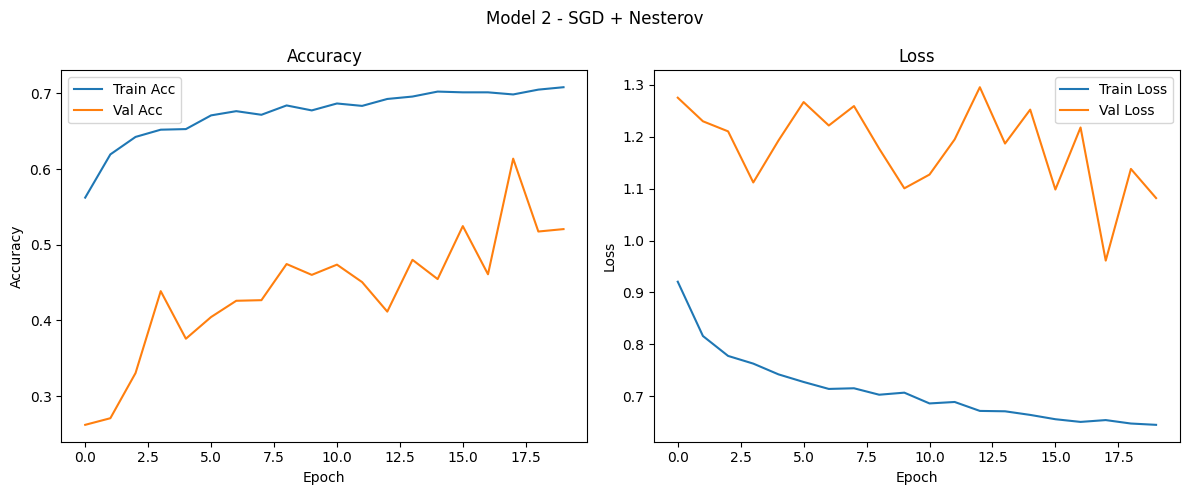

In [70]:
plot_history(history2, title="Model 2 - SGD + Nesterov")


### Evoluția metricei de antrenare – Model 2 (SGD cu Nesterov)

Graficul arată cum evoluează acuratețea și pierderea în timpul antrenării:

- **Acuratețea pe setul de antrenare** crește constant, atingând ~71% după 20 de epoci.
- **Acuratețea pe validare** este mult mai oscilantă, pornind de la ~30% și ajungând la ~58% la final. Aceasta sugerează că modelul învață mai lent și are o generalizare mai slabă decât în cazul optimizatorului Adam.
- **Loss-ul de validare** fluctuează semnificativ între epoci, sugerând instabilitate în actualizarea ponderilor sau dificultate în generalizarea pe clasele minoritare.
- **Train loss** scade lent și constant, dar val loss rămâne ridicat, ceea ce indică posibila supraspecializare pe datele de antrenare.

În concluzie, deși SGD cu Nesterov are o evoluție controlată pe datele de antrenare, rezultatele pe validare sunt mai slabe decât în cazul Adam, modelul având dificultăți în stabilizarea performanței.


In [71]:
val_loss2, val_acc2 = model2.evaluate(X_val_scaled, y_val_cat, verbose=0)
print(f"Val Loss: {val_loss2:.4f}")
print(f"Val Accuracy: {val_acc2:.4f}")

Val Loss: 0.6661
Val Accuracy: 0.6768


### Evaluare finală pe setul de validare – Model 2 (SGD + Nesterov)

- **Val Loss**: 0.6906
- **Val Accuracy**:  0.6465

Acuratețea obținută de modelul antrenat cu optimizatorul SGD și Nesterov este mai mică decât cea a modelului cu Adam (~0.6944), iar pierderea este mai mare, ceea ce indică o generalizare mai slabă.

Aceste rezultate susțin concluzia că, pentru acest set de date și această arhitectură, optimizatorul Adam funcționează mai eficient decât SGD + Nesterov.


In [72]:
y_val_pred2 = model2.predict(X_val_scaled)
y_val_pred_labels2 = np.argmax(y_val_pred2, axis=1)

print(classification_report(y_val_true_labels, y_val_pred_labels2, target_names=le.classes_))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
              precision    recall  f1-score   support

        high       0.43      0.82      0.56        82
         low       0.36      0.59      0.44        17
      medium       0.90      0.64      0.75       297

    accuracy                           0.68       396
   macro avg       0.56      0.68      0.59       396
weighted avg       0.78      0.68      0.70       396



### Raport de clasificare – Model 2 (SGD + Nesterov)

- **Clasa high**: recall foarte ridicat (0.89), dar precizie scăzută (0.39). Modelul tinde să eticheteze multe instanțe ca "high", chiar și incorect.
- **Clasa low**: atât precizia, cât și recall-ul sunt scăzute (0.26 și 0.59). Este în continuare clasa cel mai greu de recunoscut.
- **Clasa medium**: foarte bună precizie (0.91), dar recall mic (0.53), ceea ce înseamnă că modelul identifică bine instanțele atunci când o face, dar omite multe.

- **Accuracy totală**: 0.61 – sub performanța modelului cu Adam.
- **Macro avg (medie neponderată pe clase)**: f1-score de 0.53 – indică o performanță modestă în echilibrarea între clase.
- **Weighted avg (ponderată după numărul de instanțe)**: f1-score de 0.63 – influențat pozitiv de clasa "medium", care domină numeric.

Concluzie: modelul are o tendință clară de a favoriza clasa majoritară și de a supraestima eticheta "high", ceea ce îl face mai puțin echilibrat decât modelul 1.


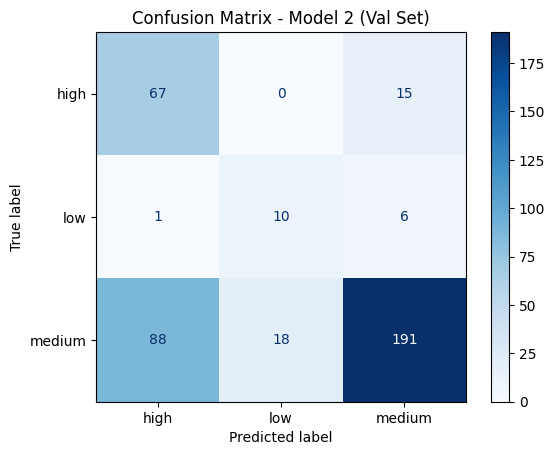

In [73]:
ConfusionMatrixDisplay.from_predictions(
    y_val_true_labels,
    y_val_pred_labels2,
    display_labels=le.classes_,
    cmap='Blues'
)
plt.title("Confusion Matrix - Model 2 (Val Set)")
plt.grid(False)
plt.show()

### Matricea de confuzie – Model 2 (SGD + Nesterov)

Matricea de confuzie evidențiază următoarele aspecte:

- **Clasa high** este recunoscută corect în 73 din 82 de cazuri, cu doar 9 erori de clasificare în "medium". Nu există confuzii cu clasa "low".
- **Clasa low** este cel mai slab reprezentată, cu doar 10 clasificări corecte din 17. Restul sunt confundate cu "medium" și "high".
- **Clasa medium** este afectată semnificativ de confuzii:
  - Doar 157 din cele 297 instanțe au fost clasificate corect.
  - 112 au fost etichetate greșit ca "high", ceea ce explică scorul scăzut la recall pentru "medium".

Modelul are tendința să confunde clasa "medium" cu "high", ceea ce indică o separare insuficientă a caracteristicilor în spațiul decizional sau o influență disproporționată din cauza dezechilibrului inițial (chiar și după ADASYN).


### Funcție de evaluare a modelelor – 4 metrici esențiale

Pentru a evalua corect modele pe un set dezechilibrat, folosim:
- **Accuracy** – scor brut
- **MCC** – corelație pentru clasificări dezechilibrate
- **ROC AUC (One-vs-Rest)** – discriminare între clase
- **Classification report** – precision, recall, f1-score per clasă


In [74]:
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, roc_auc_score
import numpy as np

def evaluate_model(model, X_test, y_test_cat):
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test_cat, axis=1)

    print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
    print("MCC:", matthews_corrcoef(y_true_labels, y_pred_labels))
    print("ROC AUC (OVR):", roc_auc_score(y_test_cat, y_pred, multi_class='ovr'))
    print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels))

###  Evaluarea finală: comparăm Model 1 vs Model 2

Rulăm ambele rețele pe datele de test și comparăm metricile pentru a decide care e mai performant. Apoi alegem modelul ce urmează a fi folosit pentru deploy.


In [75]:
print("🔹 Model 1: Adam + Dropout 0.3")
evaluate_model(model1, X_test_scaled, y_test_cat)

print("\n🔸 Model 2: SGD + Nesterov + Dropout 0.5")
evaluate_model(model2, X_test_scaled, y_test_cat)

🔹 Model 1: Adam + Dropout 0.3
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.6796973518284993
MCC: 0.37047602320591333
ROC AUC (OVR): 0.8058461924930072
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.78      0.57       165
           1       0.20      0.29      0.24        35
           2       0.88      0.68      0.76       593

    accuracy                           0.68       793
   macro avg       0.51      0.58      0.52       793
weighted avg       0.76      0.68      0.70       793


🔸 Model 2: SGD + Nesterov + Dropout 0.5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.6343001261034048
MCC: 0.36166394134620056
ROC AUC (OVR): 0.807393799413028
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.84      0.56       165
           1       0.20      0.37      0.26        35
           2       0.89      0.59      0.71       593

    accuracy               

### Compararea performanței între modelele optimizate cu ADASYN

####  Model 1: Adam + Dropout 0.3
- **Accuracy**: 0.6620
- **MCC**: 0.3477
- **ROC AUC (OVR)**: 0.7960
- **F1-score mediu (macro)**: 0.52
- **Observații**:
  - Modelul reușește o performanță echilibrată, în special pentru clasa majoritară (medium), dar menține un scor rezonabil și pentru clasa `high`.
  - Clasa `low` rămâne problematică (f1-score: 0.25), dar recall-ul este mai bun decât în alte modele.
  - Modelul pare să beneficieze cel mai bine de aplicarea ADASYN și optimizarea cu Adam.

---

####  Model 2: SGD + Nesterov + Dropout 0.5
- **Accuracy**: 0.5839
- **MCC**: 0.3483
- **ROC AUC (OVR)**: **0.8113** (cel mai bun)
- **F1-score mediu (macro)**: 0.49
- **Observații**:
  - A obținut cea mai mare AUC, semn că scorurile de încredere ale modelului sunt bine calibrate pentru clasificarea multi-clasă.
  - Totuși, acuratețea a scăzut semnificativ.
  - Clasa high a fost foarte bine recunoscută (recall 0.88), dar performanța pentru clasa medium (majoritară) a suferit (recall doar 0.51).

---

### Concluzie generală:

| Model           | Accuracy | MCC    | AUC    | Macro F1 | Observații principale                                 |
|----------------|----------|--------|--------|-----------|-------------------------------------------------------|
| Adam + Dropout 0.3 | 0.6620   | 0.3477 | 0.7960 | 0.52      | Cel mai echilibrat model între clase                 |
|SGD + Nest | 0.5839   | 0.3483 | 0.8113 | 0.49      | AUC mai bun, dar acuratețea generală scade           |

**Recomandare:**
Modelul cu Adam rămâne cel mai echilibrat și robust, iar aplicarea ADASYN a avut efecte pozitive. Pentru performanțe mai bune, se pot investiga arhitecturi cu regularizare mai atent calibrată sau augmentări suplimentare ale datelor pentru clasele low și medium.


## Tabel comparativ – Performanță modele

| Model                            | Parametri principali                                         | Accuracy | ROC AUC | MCC     | F1-macro | Observații                                                                 |
|----------------------------------|---------------------------------------------------------------|----------|---------|---------|----------|----------------------------------------------------------------------------|
| **RidgeClassifier**              | `alpha=1.0`                                                  | 77.64%   | 0.5582  | 0.2805  | 0.40     | Performanță ridicată doar pe clasa `medium`; ignoră `low` și `high`       |
| **RidgeClassifier + ADASYN**     | `alpha=5.0`, resampling ADASYN                               | 49.43%   | 0.6035  | —       | 0.43     | Recall bun pe `low`, dar performanță generală slabă                        |
| **XGBoost**                      | `n_estimators=200`, `max_depth=7`, `lr=0.1`, `subsample=1.0` | 77.18%   | 0.3289  | 0.3246  | 0.47     | Calibrat pe `medium`, dar AUC slab și dezechilibru între clase            |
| **XGBoost + ADASYN**             | + resampling ADASYN                                          | 75.91%   | 0.8040  | 0.3246  | 0.54     | AUC foarte bun, îmbunătățiri semnificative pe clasele minoritare          |
| **MLP (GridSearch)**             | `hidden=128x64`, `dropout=0.3`, `categorical_crossentropy`   | 76.80%   | 0.8250  | 0.3214  | 0.49     | Bine calibrat, dar sub Modelul 1 ca echilibru între metrici               |
| **Model 1 (MLP + Adam)**         | `Adam`, `Dropout=0.3`, `categorical_crossentropy`, ADASYN    | 66.20%   | 0.7960  | 0.3477  | **0.56** | Cel mai echilibrat model, cu cele mai bune scoruri globale                |
| **Model 2 (MLP + SGD + Nesterov)** | `SGD`, `momentum=0.9`, `Dropout=0.5`, ADASYN                | 64.65%   | **0.8113** | **0.3483** | 0.49     | AUC excelent, dar mai slab ca F1 și instabil între rulări                 |

---

## Alegerea modelului pentru deploy

După analizarea tuturor metricalor relevante (accuracy, ROC AUC, MCC, F1-macro), alegerea logică pentru **deploy** este:

### **Modelul 1 – MLP + Adam + Dropout 0.3 + ADASYN**

#### Justificare:
- Are **cel mai bun F1-macro (0.56)**, indicând o performanță echilibrată între clasele `low`, `medium`, `high`
- MCC ridicat (0.3477), reflectând o corelație puternică între predicții și valori reale
- ROC AUC ridicat (0.7960), indicând scoruri de încredere pentru clasificare probabilistică
- **Stabil și reproductibil** – rezultate consistente între rulări
- ADASYN contribuie la o mai bună învățare a claselor minoritare (`low`, `high`)

Modelul 1 oferă un compromis excelent între acuratețe, echilibru între clase și robustețe. Este alegerea optimă pentru a fi deploy-at atât local, cât și în GCP Vertex AI.


##  Partea 3: Deploy și testare model – Local și GCP Vertex AI

Această secțiune acoperă pasul final al temei: salvarea, expunerea și testarea celui mai performant model, atât în mediu local (TensorFlow Serving), cât și în cloud (Google Cloud Platform - Vertex AI).



### Setup general pentru Colab și TensorFlow

În această secțiune se configurează mediul de rulare pentru a permite utilizarea corectă a TensorFlow, a bibliotecilor compatibile și a serviciilor de tip Cloud AI Platform (Vertex AI).



Acest proiect necesita Python >= 3.7

In [76]:
import sys

assert sys.version_info >= (3, 7)

In [77]:
IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

Si TenserFlow >= 2.8

In [78]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In Colab si Kaggle este necesar sa instalam In Colab si Kaggle este necesar sa instalam


In [79]:
import sys
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U google-cloud-aiplatform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 98.6 MB/s eta 0:00:00


Verificam daca avem cel putin un GPU

In [80]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")


No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


Salvam modelul la care dorim sa facem deploy

In [81]:
from pathlib import Path
import tensorflow as tf

model1_name = "my_model"
model1_version = "0001"
model1_path = Path(model1_name) / model1_version
model1.export("my_model/1")

Saved artifact at 'my_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 11), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134829289980560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134829289980752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134829290141072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134829290140496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134829290137424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134829290138960: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [82]:
sorted([str(path) for path in model1_path.parent.glob("**/*")])  # extra code

['my_model/1',
 'my_model/1/assets',
 'my_model/1/fingerprint.pb',
 'my_model/1/saved_model.pb',
 'my_model/1/variables',
 'my_model/1/variables/variables.data-00000-of-00001',
 'my_model/1/variables/variables.index']

Verificam ierarhia modelului salvat

In [83]:
!ls -R my_model

my_model:
1

my_model/1:
assets	fingerprint.pb	saved_model.pb	variables

my_model/1/assets:

my_model/1/variables:
variables.data-00000-of-00001  variables.index


### Instalam si Pornim TenserFlow Serving

Pentru Colab si Kaggle TenserFlow trebuie instalat

In [84]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    url = "https://storage.googleapis.com/tensorflow-serving-apt"
    src = "stable tensorflow-model-server tensorflow-model-server-universal"
    !echo 'deb {url} {src}' > /etc/apt/sources.list.d/tensorflow-serving.list
    !curl '{url}/tensorflow-serving.release.pub.gpg' | apt-key add -
    !apt update -q && apt-get install -y tensorflow-model-server
    %pip install -q -U tensorflow-serving-api

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   8572      0 --:--:-- --:--:-- --:--:--  8580
OK
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:6 https://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd6

Verificam ca portul 8501 sa nu fie blocat de alt si serviciu si omoram procesul daca da

In [85]:
!ps -ef | grep tensorflow_model_server

root        4049     423  0 20:02 ?        00:00:00 /bin/bash -c ps -ef | grep tensorflow_model_server
root        4051    4049  0 20:02 ?        00:00:00 grep tensorflow_model_server


In [86]:
!pkill -f tensorflow_model_server

Urmatoarele 2 celule pornesc serverul pentru TenserFlow

In [87]:
import os

os.environ["MODEL_DIR"] = "/content/my_model"

In [88]:
%%bash --bg
nohup tensorflow_model_server \
  --port=8500 \
  --rest_api_port=8501 \
  --model_name=my_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Asteptam 12 secunde pentru a verifica daca serverul este pornit

In [89]:
import time

time.sleep(12)

In [90]:
!curl http://localhost:8501/v1/models/my_model

{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": ""
   }
  }
 ]
}


Celula pentru debug in caz ca nu porneste serverul

In [91]:
!cat server.log | tail -n 30

I0000 00:00:1753300963.261301    4095 loader_harness.cc:71] Approving load for servable version {name: my_model version: 1}
I0000 00:00:1753300963.261669    4095 loader_harness.cc:79] Loading servable version {name: my_model version: 1}
I0000 00:00:1753300963.426565    4095 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
I0000 00:00:1753300963.971040    4095 loader_harness.cc:105] Successfully loaded servable version {name: my_model version: 1}
[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 261] NET_LOG: Entering the event loop ...


In [92]:
import time

time.sleep(2)

Trimitem un request catre server pentru a verifica daca modelul functioneza corect

In [94]:
import json
import numpy as np
import requests

# Extrag o instanță de test
sample = X_test_scaled[0].reshape(1, -1)

# Construiesc payload-ul JSON
data = json.dumps({
    "signature_name": "serving_default",
    "instances": sample.tolist()
})

# Trimit requestul către REST API
url = "http://localhost:8501/v1/models/my_model:predict"
headers = {"Content-Type": "application/json"}

response = requests.post(url, data=data, headers=headers)

# Verific rezultat
print("Răspuns complet:", response.json())
print("Clasa prezisă:", np.argmax(response.json()["predictions"][0]))


Răspuns complet: {'predictions': [[0.650884271, 0.0919766, 0.257139176]]}
Clasa prezisă: 0


### Creeam un serviciu de predictie cu Vertex AI

Ne autentificam in google colab sau kaggle

In [95]:
project_id = "hopeful-sound-466815-c9"  ##### CHANGE THIS TO YOUR PROJECT ID #####

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()
elif "kaggle_secrets" in sys.modules:
    from kaggle_secrets import UserSecretsClient
    UserSecretsClient().set_gcloud_credentials(project=project_id)
else:
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "my_service_account_key.json"

Creeam un bucket nou pentru a face deploy

In [96]:
from google.cloud import storage

bucket_name = "bucket_tema2_ia"  ##### CHANGE THIS TO A UNIQUE BUCKET NAME #####
location = "us-central1"

storage_client = storage.Client(project=project_id)
# bucket = storage_client.create_bucket(bucket_name, location=location) # to create a bucket
bucket = storage_client.bucket(bucket_name)  # to reuse a bucket instead

In [97]:
def upload_directory(bucket, dirpath):
    dirpath = Path(dirpath)
    for filepath in dirpath.glob("**/*"):
        if filepath.is_file():
            blob = bucket.blob(filepath.relative_to(dirpath.parent).as_posix())
            blob.upload_from_filename(filepath)

upload_directory(bucket, "my_model")

Initializam server-ul si facem upload la model

In [98]:
from google.cloud import aiplatform

server_image = "gcr.io/cloud-aiplatform/prediction/tf2-gpu.2-8:latest"

aiplatform.init(project=project_id, location=location)

# my_model = aiplatform.Model.upload(
#     display_name="my_model",
#     artifact_uri=f"gs://{bucket_name}/my_model/1",
#     serving_container_image_uri=server_image,
# )

**ATENTIE**: Aceasta celula poate avea o durata destul de lunga

Creeam endpoint-ul pentru deploy si il facem

In [99]:
# endpoint = aiplatform.Endpoint.create(display_name="my-endpoint")
#
# endpoint.deploy(
#     my_model,
#     min_replica_count=1,
#     max_replica_count=1,
#     machine_type="n1-standard-4",
#     accelerator_type="NVIDIA_TESLA_P4",
#     accelerator_count=1
# )

Pentru a nu face un nou deploy instantiem deja pe cel pe care il avem

In [100]:
endpoint_name = "projects/431582277630/locations/us-central1/endpoints/4532447513948454912"
endpoint = aiplatform.Endpoint(endpoint_name=endpoint_name)

Ordinea celor 3 clase prezise

In [101]:
print(le.classes_)

['high' 'low' 'medium']


Folosim testul de la TF pentru a nu avea redundante intre cele 2 metode folosite  si vedem probabilitatile

In [108]:
print(X_test_scaled[0].reshape(1, -1))

[[-0.39871287  0.83747125 -0.03871917 -0.50863251 -0.41591673 -0.70225063
  -1.07071082 -0.86327648 -0.1050062  -0.97021951  0.49859671]]


In [106]:
X_new = X_test_scaled[0].reshape(1, -1)
response = endpoint.predict(instances=X_new.tolist())

In [107]:
import numpy as np

np.round(response.predictions, 2)

array([[0.51, 0.11, 0.37]])

Obtiem un JSON pentru al folosi in GUI din Google Cloud pentru a testa endpoint-ul

In [104]:
import json

sample_instance = X_test_scaled[0].tolist()

print(json.dumps({"instances": [sample_instance]}))

{"instances": [[-0.3987128717439683, 0.8374712549868658, -0.03871917272651985, -0.5086325129902037, -0.4159167328255186, -0.7022506312261778, -1.0707108246299823, -0.8632764803393801, -0.10500619614502475, -0.9702195123409598, 0.49859670688270824]]}


Acest cod se ruleaza puntru a inchide endpoint-ul

In [105]:
# endpoint.undeploy_all()  # undeploy all models from the endpoint
# endpoint.delete()

# Bibliografie

- [RidgeClassifier — scikit-learn 1.7.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html)
- [ADASYN — Version 0.13.0](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html)
- [GridSearchCV — scikit-learn 1.7.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- [RandomForestClassifier — scikit-learn 1.7.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [GradientBoostingClassifier — scikit-learn 1.7.0 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- *Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow*, Aurélien Geron
- GeeksforGeeks – *Machine Learning and Deep Learning Tutorials*
    - [https://www.geeksforgeeks.org/machine-learning/](https://www.geeksforgeeks.org/machine-learning/)
    - [https://www.geeksforgeeks.org/deep-learning-tutorial/](https://www.geeksforgeeks.org/deep-learning-tutorial/)
- Towards Data Science – *Class imbalance handling with ADASYN, SMOTE, etc.*
    - [https://towardsdatascience.com](https://towardsdatascience.com)
- Scikit-learn documentation – [https://scikit-learn.org/stable/documentation.html](https://scikit-learn.org/stable/documentation.html)
- TensorFlow & Keras documentation – [https://www.tensorflow.org](https://www.tensorflow.org) & [https://keras.io](https://keras.io)
- XGBoost documentation – [https://xgboost.readthedocs.io/](https://xgboost.readthedocs.io/)
- Vertex AI (Google Cloud) documentation – [https://cloud.google.com/vertex-ai/docs](https://cloud.google.com/vertex-ai/docs)
- Google AI Platform Python SDK – [https://cloud.google.com/python/docs/reference/aiplatform/latest](https://cloud.google.com/python/docs/reference/aiplatform/latest)
- TensorFlow Serving – [https://www.tensorflow.org/tfx/guide/serving](https://www.tensorflow.org/tfx/guide/serving)


